View the Time series providing Article ID

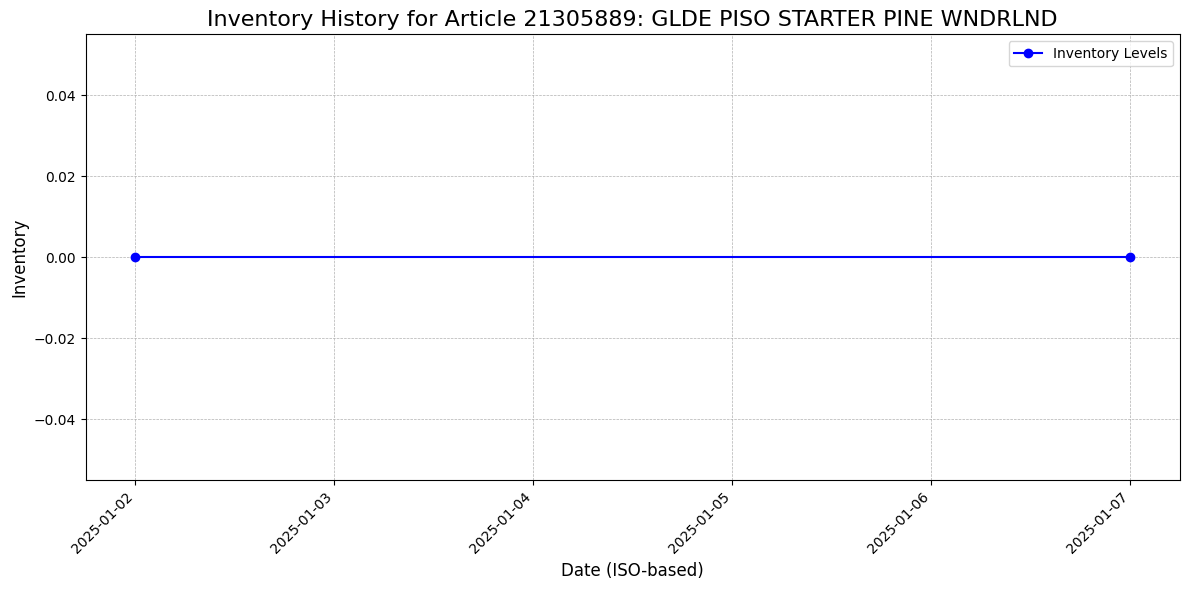

In [18]:
#!/usr/bin/env python3
# iso_based_timeseries.py

import psycopg2
import matplotlib.pyplot as plt
from datetime import date, datetime, timedelta
import matplotlib.dates as mdates
import json

# ------------------------------------------------------------------------------
# 1. Database configuration
# ------------------------------------------------------------------------------
sb_config = json.load(open('config.json'))
# ------------------------------------------------------------------------------
# 2. Convert (ISO year, ISO week, ISO day=1..7) to a date
# ------------------------------------------------------------------------------
def iso_to_date(iso_year: int, iso_week: int, iso_day: int) -> date:
    """
    Convert an ISO year-week-day combination (e.g. 2025, 2, 2)
    into a Python date object (2025-01-07).

      - iso_year: The ISO-8601 year (which can differ from calendar year near boundaries).
      - iso_week: The ISO week number (1..53).
      - iso_day:  1=Monday .. 7=Sunday (ISO-8601).

    Returns:
        A datetime.date object representing the actual (Gregorian) date.
    """
    # Step 1: January 4 is always in ISO week 1.
    january_4 = date(iso_year, 1, 4)

    # Step 2: Find Monday of ISO week 1
    #   isoweekday() => Monday=1, Tuesday=2, ..., Sunday=7.
    #   Subtract (january_4.isoweekday() - 1) days to get that Monday.
    first_monday = january_4 - timedelta(days=january_4.isoweekday() - 1)

    # Step 3: From that Monday, move forward (iso_week - 1) weeks
    #         plus (iso_day - 1) days.
    return first_monday + timedelta(weeks=(iso_week - 1), days=(iso_day - 1))

# ------------------------------------------------------------------------------
# 3. Fetch time-series data from PostgreSQL
# ------------------------------------------------------------------------------
def fetch_time_series(article_id, start_week, end_week):
    """
    Fetches inventory data from the database for the specified article
    and week range. Returns (rows, product_description, article_id).

    Each row in 'rows' will look like:
      (year, week, D0, D1, D2, D3, D4, D5, D6)
    where D0 is Monday’s inventory, D6 is Sunday’s.
    """
    conn = None
    try:
        conn = psycopg2.connect(
            host=db_config['host'],
            dbname=db_config['dbname'],
            user=db_config['user'],
            password=db_config['password'],
            port=db_config['port']
        )
        cur = conn.cursor()

        # 1) Fetch product description
        cur.execute(
            "SELECT description FROM Products WHERE article_number = %s",
            (article_id,)
        )
        description_result = cur.fetchone()
        if not description_result:
            print(f"No product found for Article ID: {article_id}")
            return None, None, None
        product_description = description_result[0]

        # 2) Fetch time-series data
        sql_query = """
        SELECT DC.year, DC.week, DC.D0_inventory, DC.D1_inventory, DC.D2_inventory,
               DC.D3_inventory, DC.D4_inventory, DC.D5_inventory, DC.D6_inventory
        FROM DailyCheckIn AS DC
        JOIN Products AS P ON DC.product_id = P.id
        WHERE P.article_number = %s
          AND DC.week >= %s
          AND DC.week <= %s
        ORDER BY DC.year, DC.week
        """
        cur.execute(sql_query, (article_id, start_week, end_week))
        rows = cur.fetchall()

        return rows, product_description, article_id

    except psycopg2.Error as e:
        print(f"Database error: {e}")
        return None, None, None
    finally:
        if conn:
            conn.close()

# ------------------------------------------------------------------------------
# 4. Plot the time series (using iso_to_date)
# ------------------------------------------------------------------------------
def plot_time_series(rows, product_description, article_id):
    """
    rows is a list of tuples: (iso_year, iso_week, D0, D1, D2, D3, D4, D5, D6)
      where D0 corresponds to Monday's inventory (iso_day=1),
      D1 => Tuesday (iso_day=2), etc.

    We'll:
      1) Convert each non-None inventory to (date, inventory).
      2) Sort by date.
      3) Plot, deciding on daily vs. weekly labeling based on total days spanned.
    """
    if not rows:
        print("No data to plot.")
        return

    all_dates = []
    all_inventories = []

    # Convert each row to potential 7 daily data points
    for (yr, wk, D0, D1, D2, D3, D4, D5, D6) in rows:
        daily_invs = [D0, D1, D2, D3, D4, D5, D6]
        for day_num, inv in enumerate(daily_invs):
            if inv is None:
                continue
            # day_num=0 => Monday => iso_day=1
            # day_num=1 => Tuesday => iso_day=2
            iso_day = day_num + 1  # map 0..6 -> 1..7
            dt = iso_to_date(yr, wk, iso_day)
            all_dates.append(dt)
            all_inventories.append(inv)

    if not all_dates:
        print("No valid data to plot after filtering None.")
        return

    # Sort by the date
    paired = sorted(zip(all_dates, all_inventories), key=lambda x: x[0])
    plot_dates, plot_values = zip(*paired)

    # Create a figure
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(plot_dates, plot_values, marker='o', linestyle='-', color='blue',
            label="Inventory Levels")

    ax.set_title(f"Inventory History for Article {article_id}: {product_description}", fontsize=16)
    ax.set_xlabel("Date (ISO-based)", fontsize=12)
    ax.set_ylabel("Inventory", fontsize=12)

    # Decide daily vs. weekly tick labeling based on total range
    day_span = (plot_dates[-1] - plot_dates[0]).days
    if day_span <= 14:
        # Label every day
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    else:
        # Label weekly (on Mondays) or use AutoDateLocator
        ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    # Rotate tick labels for readability
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    # Grid lines
    ax.grid(True, which='major', linestyle='--', linewidth=0.5)
    ax.legend()
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------------------------
# 5. Example usage (adjust article_id, start_week, end_week as needed)
# ------------------------------------------------------------------------------
if __name__ == "__main__":
    article_id = "21305889"
    start_week = 0
    end_week = 2

    rows, description, article_id = fetch_time_series(article_id, start_week, end_week)
    plot_time_series(rows, description, article_id)


Retreving Data Using Pytorch

In [ ]:
import psycopg2
import pandas as pd
import torch

# Database configuration
b_config = json.load(open('config.json'))
# Query to fetch data
query = """
SELECT 
    P.article_number,
    P.category,
    P.department,
    DC.d0_inventory,
    DC.d1_inventory,
    DC.d2_inventory,
    DC.d3_inventory,
    DC.d4_inventory,
    DC.d5_inventory,
    DC.d6_inventory
FROM 
    public.dailycheckin DC
JOIN 
    public.products P
ON 
    P.id = DC.product_id
ORDER BY 
    P.article_number, DC.year, DC.week;
"""

# Fetch data from PostgreSQL
def fetch_data_from_db():
    conn = psycopg2.connect(**db_config)
    df = pd.read_sql(query, conn)
    conn.close()
    return df

# Map categories and departments to IDs
def create_mappings(df):
    category_mapping = {cat: idx for idx, cat in enumerate(df['category'].unique())}
    department_mapping = {dept: idx for idx, dept in enumerate(df['department'].unique())}
    product_mapping = {prod: idx for idx, prod in enumerate(df['article_number'].unique())}
    return product_mapping, category_mapping, department_mapping

# Convert data to PyTorch tensors
def prepare_tensors(df, product_mapping, category_mapping, department_mapping):
    # Map product, category, and department to indices
    df['product_id'] = df['article_number'].map(product_mapping)
    df['category_id'] = df['category'].map(category_mapping)
    df['department_id'] = df['department'].map(department_mapping)

    # Prepare feature matrix (inventory columns)
    inventory_features = df[['d0_inventory', 'd1_inventory', 'd2_inventory', 
                              'd3_inventory', 'd4_inventory', 'd5_inventory', 
                              'd6_inventory']].fillna(0).values

    # Convert to tensors
    inventory_features_tensor = torch.tensor(inventory_features, dtype=torch.float)
    product_ids_tensor = torch.tensor(df['product_id'].values, dtype=torch.long)
    category_ids_tensor = torch.tensor(df['category_id'].values, dtype=torch.long)
    department_ids_tensor = torch.tensor(df['department_id'].values, dtype=torch.long)

    return inventory_features_tensor, product_ids_tensor, category_ids_tensor, department_ids_tensor

# Main function to fetch and process data
def main():
    print("Fetching data from database...")
    df = fetch_data_from_db()
    print(f"Data fetched. Total rows: {len(df)}")

    # Create mappings for product, category, and department
    product_mapping, category_mapping, department_mapping = create_mappings(df)

    # Prepare tensors
    inventory_features, product_ids, category_ids, department_ids = prepare_tensors(
        df, product_mapping, category_mapping, department_mapping
    )
    print("Data converted to tensors.")
    print(f"Inventory Features Tensor Shape: {inventory_features.shape}")
    print(f"Product IDs Tensor Shape: {product_ids.shape}")
    print(f"Category IDs Tensor Shape: {category_ids.shape}")
    print(f"Department IDs Tensor Shape: {department_ids.shape}")

    return inventory_features, product_ids, category_ids, department_ids

if __name__ == "__main__":
    inventory_features, product_ids, category_ids, department_ids = main()


In [ ]:
import psycopg2
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import json

# Database configuration
db_config = json.load(open('config.json'))

# Query to fetch data
query = """
SELECT 
    P.article_number,
    P.category,
    P.department,
    DC.d0_inventory,
    DC.d1_inventory,
    DC.d2_inventory,
    DC.d3_inventory,
    DC.d4_inventory,
    DC.d5_inventory,
    DC.d6_inventory
FROM 
    public.dailycheckin DC
JOIN 
    public.products P
ON 
    P.id = DC.product_id
ORDER BY 
    P.article_number, DC.year, DC.week;
"""

# Category Prediction Model
class CategoryPredictionModel(nn.Module):
    def __init__(self, num_categories, num_departments, embed_dim=8):
        super(CategoryPredictionModel, self).__init__()
        # Embedding layer for department
        self.department_embedding = nn.Embedding(num_departments, embed_dim)
        
        # Fully connected layers
        self.fc1 = nn.Linear(embed_dim + 7, 64)  # Embedding + 7 inventory features
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_categories)  # Output: number of categories (classes)

    def forward(self, inventory_features, department_ids):
        # Embedding lookup
        dept_emb = self.department_embedding(department_ids)
        
        # Combine embeddings and inventory features
        combined = torch.cat((inventory_features, dept_emb), dim=1)
        
        # Fully connected layers
        x = torch.relu(self.fc1(combined))
        x = torch.relu(self.fc2(x))
        output = self.fc3(x)  # Output logits for classification
        return output


In [ ]:
def fetch_data_from_db():
    conn = psycopg2.connect(**db_config)
    df = pd.read_sql(query, conn)
    conn.close()
    return df

def prepare_category_data(df):
    # Encode category as labels
    category_encoder = LabelEncoder()
    df['category_encoded'] = category_encoder.fit_transform(df['category'])

    # Map department to indices
    department_mapping = {dept: idx for idx, dept in enumerate(df['department'].unique())}
    df['department_id'] = df['department'].map(department_mapping)

    # Prepare tensors
    inventory_features = torch.tensor(df[['d0_inventory', 'd1_inventory', 'd2_inventory', 
                                           'd3_inventory', 'd4_inventory', 'd5_inventory', 
                                           'd6_inventory']].fillna(0).values, dtype=torch.float)
    department_ids = torch.tensor(df['department_id'].values, dtype=torch.long)
    category_labels = torch.tensor(df['category_encoded'].values, dtype=torch.long)

    return inventory_features, department_ids, category_labels, len(department_mapping), len(category_encoder.classes_), category_encoder

def train_category_prediction_model():
    print("Fetching data...")
    df = fetch_data_from_db()

    print("Preparing data...")
    inventory_features, department_ids, category_labels, num_departments, num_categories, category_encoder = prepare_category_data(df)

    # Train-test split
    X_train, X_test, dept_train, dept_test, y_train, y_test = train_test_split(
        inventory_features, department_ids, category_labels, test_size=0.2, random_state=42
    )

    # Initialize model, loss, optimizer
    model = CategoryPredictionModel(num_categories, num_departments)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    epochs = 10
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(X_train, dept_train)
        loss = criterion(outputs, y_train)
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}")

    # Testing loop
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test, dept_test)
        _, predicted = torch.max(test_outputs, 1)
        accuracy = (predicted == y_test).float().mean().item()
        print(f"Test Accuracy: {accuracy * 100:.2f}%")

    return model, category_encoder

def guess_category(model, category_encoder, inventory_pattern, department):
    # Convert inputs to tensors
    inventory_tensor = torch.tensor([inventory_pattern], dtype=torch.float)
    department_tensor = torch.tensor([department], dtype=torch.long)

    # Predict category
    model.eval()
    with torch.no_grad():
        logits = model(inventory_tensor, department_tensor)
        _, predicted_class = torch.max(logits, 1)

    # Decode category
    predicted_category = category_encoder.inverse_transform(predicted_class.numpy())
    return predicted_category[0]

if __name__ == "__main__":
    model, category_encoder = train_category_prediction_model()

    # Example: Guess category
    inventory_pattern = [10, 15, 20, 25, 20, 15, 10]  # Example pattern
    department = 0  # Example department index
    category = guess_category(model, category_encoder, inventory_pattern, department)
    print(f"Predicted Category: {category}")


In [14]:
import json
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sqlalchemy import create_engine , text
import numpy as np

# Database configuration
db_config = json.load(open('config.json'))

# SQLAlchemy connection string
connection_string = f"postgresql://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['dbname']}"

# Query to fetch data
query = """
SELECT 
    P.article_number,
    P.category,
    P.department,
    P.description,
    DC.d0_inventory,
    DC.d1_inventory,
    DC.d2_inventory,
    DC.d3_inventory,
    DC.d4_inventory,
    DC.d5_inventory,
    DC.d6_inventory
FROM 
    public.dailycheckin DC
JOIN 
    public.products P
ON 
    P.id = DC.product_id
ORDER BY 
    P.article_number, DC.year, DC.week;
"""

# Product Vectorization Model
class ProductVectorizationModel(nn.Module):
    def __init__(self, num_products, num_categories, num_departments, embed_dim=8, vector_dim=16):
        super().__init__()
        # Embedding layers
        self.product_embedding = nn.Embedding(num_products, embed_dim)
        self.category_embedding = nn.Embedding(num_categories, embed_dim)
        self.department_embedding = nn.Embedding(num_departments, embed_dim)
        
        # Fully connected layers for vectorization
        self.fc1 = nn.Linear(embed_dim * 3 + 7, 64)  # Embeddings + 7 inventory features
        self.fc2 = nn.Linear(64, vector_dim)  # Output: Latent vector representation

    def forward(self, inventory_features, product_ids, category_ids, department_ids):
        # Embedding lookups
        product_emb = self.product_embedding(product_ids)
        category_emb = self.category_embedding(category_ids)
        department_emb = self.department_embedding(department_ids)
        
        # Combine embeddings and features
        combined = torch.cat((inventory_features, product_emb, category_emb, department_emb), dim=1)
        
        # Fully connected layers
        x = torch.relu(self.fc1(combined))
        latent_vector = self.fc2(x)  # Output latent vector
        return latent_vector

# Data Preparation
def fetch_data():
    engine = create_engine(connection_string)
    df = pd.read_sql(query, engine)
    return df

def clean_and_prepare_data(df):
    # Convert inventory columns to numeric
    inventory_cols = ['d0_inventory', 'd1_inventory', 'd2_inventory', 
                      'd3_inventory', 'd4_inventory', 'd5_inventory', 
                      'd6_inventory']
    df[inventory_cols] = df[inventory_cols].apply(pd.to_numeric, errors='coerce').fillna(0)

    # Create mappings
    product_mapping = {prod: idx for idx, prod in enumerate(df['article_number'].unique())}
    category_mapping = {cat: idx for idx, cat in enumerate(df['category'].unique())}
    department_mapping = {dept: idx for idx, dept in enumerate(df['department'].unique())}
    
    # Map categorical columns
    df['product_id'] = df['article_number'].map(product_mapping)
    df['category_id'] = df['category'].map(category_mapping)
    df['department_id'] = df['department'].map(department_mapping)
    
    # Prepare tensors
    inventory_features = torch.tensor(df[inventory_cols].values, dtype=torch.float)
    product_ids = torch.tensor(df['product_id'].values, dtype=torch.long)
    category_ids = torch.tensor(df['category_id'].values, dtype=torch.long)
    department_ids = torch.tensor(df['department_id'].values, dtype=torch.long)

    return inventory_features, product_ids, category_ids, department_ids, \
           len(product_mapping), len(category_mapping), len(department_mapping)

def compute_product_ranking_from_model(model, df, product_mapping, category_mapping, department_mapping):
    """
    Computes rankings for products based on their vector magnitudes using the trained model.

    Parameters:
    - model: Trained ProductVectorizationModel (already in memory)
    - df: DataFrame containing product and inventory data
    - product_mapping, category_mapping, department_mapping: Mappings used during training

    Returns:
    - ranked_df: DataFrame with products ranked by their vector magnitude
    """
    # Prepare data
    inventory_cols = ['d0_inventory', 'd1_inventory', 'd2_inventory', 
                      'd3_inventory', 'd4_inventory', 'd5_inventory', 
                      'd6_inventory']
    df[inventory_cols] = df[inventory_cols].apply(pd.to_numeric, errors='coerce').fillna(0)
    
    # Map categorical data
    df['product_id'] = df['article_number'].map(product_mapping)
    df['category_id'] = df['category'].map(category_mapping)
    df['department_id'] = df['department'].map(department_mapping)

    # Prepare tensors
    inventory_features = torch.tensor(df[inventory_cols].values, dtype=torch.float)
    product_ids = torch.tensor(df['product_id'].values, dtype=torch.long)
    category_ids = torch.tensor(df['category_id'].values, dtype=torch.long)
    department_ids = torch.tensor(df['department_id'].values, dtype=torch.long)

    # Normalize inventory features
    inventory_features = (inventory_features - inventory_features.mean(dim=0)) / (inventory_features.std(dim=0) + 1e-8)

    # Generate latent vectors
    model.eval()
    with torch.no_grad():
        latent_vectors = model(inventory_features, product_ids, category_ids, department_ids)
        vector_norms = latent_vectors.norm(dim=1).numpy()  # Compute magnitudes

    # Add vector norms to the DataFrame
    df['vector_magnitude'] = vector_norms

    # Compute rankings
    ranked_df = df[['article_number', 'category', 'department', 'vector_magnitude','description']].copy()
    ranked_df = ranked_df.groupby('description')['vector_magnitude'].mean().reset_index()
    ranked_df = ranked_df.sort_values(by='vector_magnitude', ascending=False).reset_index(drop=True)

    return ranked_df

# Example usage
def main_with_ranking():
    print("Fetching data...")
    df = fetch_data()  # Use the fetch_data function defined earlier

    print("Cleaning and preparing data...")
    inventory_features, product_ids, category_ids, department_ids, num_products, num_categories, num_departments = clean_and_prepare_data(df)

    # Train the model
    print("Training the model...")
    model = ProductVectorizationModel(num_products, num_categories, num_departments)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    epochs = 10
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        latent_vectors = model(inventory_features, product_ids, category_ids, department_ids)
        loss = criterion(latent_vectors.norm(dim=1), torch.ones_like(latent_vectors.norm(dim=1)))
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}")

    # Compute rankings
    print("Computing rankings...")
    product_mapping = {prod: idx for idx, prod in enumerate(df['article_number'].unique())}
    category_mapping = {cat: idx for idx, cat in enumerate(df['category'].unique())}
    department_mapping = {dept: idx for idx, dept in enumerate(df['department'].unique())}
    ranked_df = compute_product_ranking_from_model(model, df, product_mapping, category_mapping, department_mapping)

    print("Top 10 Strong Sellers:")
    print(ranked_df.head(10))

    print("Bottom 10 Weak Sellers:")
    print(ranked_df.tail(10))

if __name__ == "__main__":
    main_with_ranking()



Fetching data...
Cleaning and preparing data...
Training the model...
Epoch 1/10, Loss: 2.9748308658599854
Epoch 2/10, Loss: 2.472498893737793
Epoch 3/10, Loss: 2.0368943214416504
Epoch 4/10, Loss: 1.6628189086914062
Epoch 5/10, Loss: 1.3443626165390015
Epoch 6/10, Loss: 1.0760895013809204
Epoch 7/10, Loss: 0.8529066443443298
Epoch 8/10, Loss: 0.6698651313781738
Epoch 9/10, Loss: 0.5220290422439575
Epoch 10/10, Loss: 0.4045083522796631
Computing rankings...
Top 10 Strong Sellers:
                      description  vector_magnitude
0          SCOTCH BRITE SCOUR PAD          1.793417
1           FRANKS SRIRACHA SAUCE          1.670606
2       FCY FEAST VP POULTRY PLSR          1.647629
3        ROYALE ORIGINAL BT 24=48          1.635818
4          AIRWICK FM KIT MBREEZE          1.565955
5           CHIEF GREEN SEASONING          1.558508
6     RIO MARE SALMON FILT EVOOIL          1.525758
7  PC OYSTERS SMK WHOLE IN OILASC          1.519571
8         NN TUNA LT TOMATO BASIL          1.51